In [2]:
from sentence_transformers import SentenceTransformer, util
from openai import OpenAI
from tqdm import tqdm
import time

In [70]:
import numpy as np

In [2]:
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

## Set of Prompts
These prompts form the set of queries that users make ask from LLM service. We aim to do advertisement on the reponse of these queries.

In [29]:
prompts = [
    '''How to activate Internationl Roaming?''', # done
    '''Can you recommend a good recipe for chicken curry?''', # restaurants/costco
    '''How do I improve my resume for a marketing job?''', # LinkedIn/ Zety/ other CV makers/
    '''What are some tips for better sleep?''', # CVS/ Pillow-Blanket-Bed Companies/ Phone Companies
    '''Can you help me understand how cryptocurrency works?''', # RobinHood/ Fidelity/ 
    '''What are the best hiking trails near me?''', # Adidas/ Nike/ Columbia/ 
    '''Can you suggest some books similar to "To Kill a Mockingbird"?''', # Amazon Kindle/ Famous Libraries/ 
    '''What's the current population of Tokyo?''', # Expedia/ AirBNB/ Travel Agency/ 
    '''How can I improve my productivity at work?''', # IKEA/ Coffee Makers/ Earphones/
]

## Set of Advertisers
These companies are the ones that want to do advertisement. Currently, to have more efficient generation, advertisers are set per query.

In [12]:
adv_companies = [
    [ # How to activate Internationl Roaming?
        'AT&T', 'Comcast', 'Verizon', 'T-Mobile', 'Vodafone', 'Huawei',
        'Apple', 'Samsung', 'LG', 'Sony',
        'BMW', 'Costco', 'Ford', 'Kia', 'Hyundai',
    ],
    [ # Can you recommend a good recipe for chicken curry?
        'McDonald', 'KFC',
        'Costco', 'Lidl', 'Giant Food', 'ALDI',
        'BMW', 'Kia', 'Apple', 'University of Maryland', 'Google',   
    ],
    [ # How do I improve my resume for a marketing job?
        'LinkedIn', 'Zety', 'Canva', 'Resume Genius', 'Overleaf',
        'Apple', 'OpenAI', 'McDonald', 'Costco', 
    ],
    [ # What are some tips for better sleep?
        'CVS', 'IKEA', 'Serta', 'Casper', 'Brooklinen',
        'Lidl', 'ALDI', 'Sony', 'LG',
    ],
    [ # Can you help me understand how cryptocurrency works?
        'Robinhood', 'Fidelity Investments',
        'CVS', 'IKEA', 'OpenAI', 'Costco', 
    ],
    [ # What are the best hiking trails near me?
        'Adidas', 'Columbia', 'Nike', 'Expedia', 
        'Robinhood', 'Ford', 'Kia', 'Vodafone', 
    ],
    [ # Can you suggest some books similar to "To Kill a Mockingbird"?
        'Amazon','Barnes & Noble', 'Alibris',
        'Apple', 'Samsung', 'Kia', 'Ford', 'CVS',
    ],
    [ # What's the current population of Tokyo?
        'Expedia', 'Airbnb', 'Fly Emirates', 'Qatar Airways', 'United Airlines',
        'Lidl', 'BMW', 'Sony', 'LinkedIn',
    ],
    [ # How can I improve my productivity at work?
        'Starbucks', 'Nestle', 'Farmer Bros', 'IKEA', 'Sony',
        'Robinhood', 'Kia', 'Hyundai', 
    ]
]

In [69]:
prompt_for_adv = 'Give me a paragraph about {} so that I can use it to advertise this brand.'

prompt_to_add_adv = '''
{} please respond to this question while also advertise {} with this context:  "{}" 
Make sure to connect the question and the advertisement very naturally, not something like appending the ad after just answering the question. The ad should be incorporated in the middle of the response.
'''

In [32]:
def query_to_chatgpt(prompt):
    chat_completion_det = client.chat.completions.create(
        messages = [
            {
                "role": "user",
                "content": prompt
            },
            {
                "role": "assistant",
                "content": ""
            }
        ],
        model = "gpt-3.5-turbo",
        logprobs = False,
        temperature = 1,
        max_tokens = 200
    )
    return chat_completion_det.choices[0].message.content

In [33]:
query_to_chatgpt('How old is the Earth and how old is the Moon?')

'The Earth is estimated to be around 4.5 billion years old, while the Moon is thought to be about 4.5 billion years old as well, having formed around the same time as the Earth.'

In [34]:
time.sleep(0.5)

## Advertisement for Brands.
We prompt ChatGPT with `Give me a paragraph about {} so that I can use it to advertise this brand.`.

Responses will generate a set of advertisements/documents that are used later to include advertisement within the response of ChatGPT to the questions that a user asks. Similar to what we had in paper denoted by: 
$$\{\text{ad}_1, \text{ad}_2, ..., \text{ad}_n\}.$$

In [35]:
%%time

all_ads = []

for i, x in enumerate(prompts):
    query_embedding = model.encode(x)
    ads = []
    for j, c in tqdm(enumerate(adv_companies[i])):
        ads.append(query_to_chatgpt(prompt_for_adv.format(c)))
        time.sleep(0.3)
        
    all_ads.append(ads)

15it [00:50,  3.34s/it]
11it [00:34,  3.11s/it]
9it [00:26,  2.90s/it]
9it [00:27,  3.04s/it]
6it [00:32,  5.39s/it]
8it [00:26,  3.35s/it]
8it [00:26,  3.33s/it]
9it [00:26,  2.98s/it]
8it [00:24,  3.09s/it]

CPU times: user 740 ms, sys: 200 ms, total: 941 ms
Wall time: 4min 35s


## Advertisement within Output.
We prompt ChatGPT with `{} please respond to this question while also advertise {} with this context:  "{}" 
Make sure to connect the question and the advertisement very naturally, not something like appending the ad after just answering the question. The ad should be incorporated in the middle of the response.
`.

Responses will generate a set of modified outputs as well as the original ones. More precisely, for a query $x$, given $\{\text{ad}_1, \text{ad}_2, ..., \text{ad}_n\}$, we generate $y$ and $\{y_1, y_2, ..., y_n\}$ where $y_i$ is the response to query $x$ while asking LLM to include information from $\text{ad}_i$.

In [36]:
%%time

all_modified_ads = []
orig_y = []

for i, x in enumerate(prompts):
    ads = []
    for j, c in tqdm(enumerate(adv_companies[i])):
        ads.append(query_to_chatgpt(prompt_to_add_adv.format(x, c, all_ads[i][j])))
        time.sleep(0.2)
    orig_y.append(query_to_chatgpt(x))

    all_modified_ads.append(ads)

15it [00:55,  3.70s/it]
11it [00:56,  5.16s/it]
9it [00:43,  4.82s/it]
9it [00:34,  3.87s/it]
6it [00:25,  4.22s/it]
8it [00:30,  3.75s/it]
8it [00:37,  4.73s/it]
9it [00:29,  3.33s/it]
8it [00:30,  3.80s/it]


CPU times: user 760 ms, sys: 57 ms, total: 817 ms
Wall time: 6min 12s


In [38]:
def show_modified_output(prompt_id, adv_id):
    output = f'**query**: {prompts[prompt_id]}\n'
    output += f'**advertiser**: {adv_companies[prompt_id][adv_id]}\n'
    output += '=================\n'
    output += f'**original output**: {orig_y[prompt_id]}'
    output += '-----------------\n'
    output += f'**modified output**: {all_modified_ads[prompt_id][adv_id]}'
    return output

In [46]:
print(show_modified_output(3, 3)) # Casper is relevant to Sleep!

**query**: What are some tips for better sleep?
**advertiser**: Casper
**original output**: 1. Stick to a regular sleep schedule by going to bed and waking up at the same time every day, even on weekends.
2. Create a relaxing bedtime routine to signal to your body that it's time to sleep, such as taking a warm bath, reading a book, or listening to calming music.
3. Make sure your sleep environment is conducive to rest, with a comfortable mattress, supportive pillows, and a cool, dark, and quiet room.
4. Limit exposure to screens (phones, tablets, computers) before bed, as the blue light emitted can disrupt your sleep-wake cycle.
5. Avoid caffeine, nicotine, and large meals close to bedtime, as these can interfere with your ability to fall and stay asleep.
6. Get regular exercise during the day, but avoid vigorous physical activity too close to bedtime.
7. Manage stress through relaxation techniques such as deep breathing, meditation, or yoga before bed.
8. Avoid alcohol before bedtime,

In [49]:
print(show_modified_output(3, 7)) # Sony is somehow relevant to Sleep!

**query**: What are some tips for better sleep?
**advertiser**: Sony
**original output**: 1. Stick to a regular sleep schedule by going to bed and waking up at the same time every day, even on weekends.
2. Create a relaxing bedtime routine to signal to your body that it's time to sleep, such as taking a warm bath, reading a book, or listening to calming music.
3. Make sure your sleep environment is conducive to rest, with a comfortable mattress, supportive pillows, and a cool, dark, and quiet room.
4. Limit exposure to screens (phones, tablets, computers) before bed, as the blue light emitted can disrupt your sleep-wake cycle.
5. Avoid caffeine, nicotine, and large meals close to bedtime, as these can interfere with your ability to fall and stay asleep.
6. Get regular exercise during the day, but avoid vigorous physical activity too close to bedtime.
7. Manage stress through relaxation techniques such as deep breathing, meditation, or yoga before bed.
8. Avoid alcohol before bedtime, a

### Show Relevancy!

In [56]:
def show_score(prompt_id, sc, info):
    output = f'**info**: ' + info + '\n'
    output += f'**query**: {prompts[prompt_id]}\n'
    cnt = 0
    for c in adv_companies[prompt_id]:
        output += f'**advertiser**: {adv_companies[prompt_id][cnt]}: {sc[prompt_id][cnt]:.3f}\n'
        cnt += 1
    return output

### User Satisfaction

In this section, we measure how the user is satisfied with the generated modified output that includes advertisement. In order to evaluate that, we measure the values of
+ $\text{P}_{\eta}(y_i | x)$: This measures how relevant the modified output which is shown to user is to the query.
+ $\text{P}_{\eta}(y_i | y)$: This measures how relevant is the modified output to the original one that is generated without any modification.

We observe that in our experiments, both of the above are fine, in fact, LLM can include advertisement which does not significantly reduce the quality of output. We may need better measurements of those probabilities to get better results. Currently similarity in embedding space is used.

In [51]:
sim_ya_y = []
sim_ya_x = []

for i, x in enumerate(prompts):
    orig_query_embedding = model.encode(x)
    orig_y_embedding = model.encode(orig_y[i])
    passage_embedding = model.encode(all_modified_ads[i])
    
    sim_ya_y.append(util.dot_score(orig_y_embedding, passage_embedding)[0].numpy())
    sim_ya_x.append(util.dot_score(orig_query_embedding, passage_embedding)[0].numpy())

In [57]:
print(show_score(0, sim_ya_y, 'relevancy of y and y_i'))

**info**: relevancy of y and y_i
**query**: How to activate Internationl Roaming?
**advertiser**: AT&T: 0.767
**advertiser**: Comcast: 0.626
**advertiser**: Verizon: 0.674
**advertiser**: T-Mobile: 0.731
**advertiser**: Vodafone: 0.772
**advertiser**: Huawei: 0.775
**advertiser**: Apple: 0.695
**advertiser**: Samsung: 0.725
**advertiser**: LG: 0.771
**advertiser**: Sony: 0.665
**advertiser**: BMW: 0.778
**advertiser**: Costco: 0.618
**advertiser**: Ford: 0.527
**advertiser**: Kia: 0.636
**advertiser**: Hyundai: 0.736



In [59]:
print(show_score(0, sim_ya_x, 'relevancy of x and y_i'))

**info**: relevancy of x and y_i
**query**: How to activate Internationl Roaming?
**advertiser**: AT&T: 0.540
**advertiser**: Comcast: 0.475
**advertiser**: Verizon: 0.490
**advertiser**: T-Mobile: 0.507
**advertiser**: Vodafone: 0.586
**advertiser**: Huawei: 0.480
**advertiser**: Apple: 0.492
**advertiser**: Samsung: 0.497
**advertiser**: LG: 0.540
**advertiser**: Sony: 0.418
**advertiser**: BMW: 0.579
**advertiser**: Costco: 0.415
**advertiser**: Ford: 0.490
**advertiser**: Kia: 0.473
**advertiser**: Hyundai: 0.500



### Advertiser's Satisfaction

In this section, we measure how the advertisers are satisfied with the generated modified output that includes advertisement. In order to evaluate that, we measure the values of
+ $\text{P}_{\eta}(y_i | \text{ad}_i)$: This measures how relevant the modified output which is shown to user is to the advertisement.
+ $\text{P}_{\eta}(\text{ad}_i | x)$: This measures how relevant is the advertisement, to the query that the user asks.

We observe that in our experiments, embedding space can detect relevant ads and how well the advertisement is included within the original output.

In [61]:
sim_ya_a = []
sim_a_x = []

for i, x in enumerate(prompts):
    orig_query_embedding = model.encode(x)
    passage_embedding = model.encode(all_ads[i])

    sims = []
    for j in range(len(all_ads[i])):
        ad_j = all_ads[i][j]
        mod_ad_j = all_modified_ads[i][j]
        ad_j_embedding = model.encode(ad_j)
        mod_ad_j_embedding = model.encode([mod_ad_j])
        
        sim = util.dot_score(ad_j_embedding, mod_ad_j_embedding)[0][0].item()
        sims.append(sim)

    sim_ya_a.append(sims)
    sim_a_x.append(util.dot_score(orig_query_embedding, passage_embedding)[0].numpy())

In [66]:
print(show_score(3, sim_a_x, 'relevancy of x and ad_i'))

**info**: relevancy of x and ad_i
**query**: What are some tips for better sleep?
**advertiser**: CVS: 0.025
**advertiser**: IKEA: 0.026
**advertiser**: Serta: 0.278
**advertiser**: Casper: 0.268
**advertiser**: Brooklinen: 0.288
**advertiser**: Lidl: 0.048
**advertiser**: ALDI: -0.002
**advertiser**: Sony: -0.025
**advertiser**: LG: -0.008



In [67]:
print(show_score(3, sim_ya_a, 'relevancy of ad_i and y_i'))

**info**: relevancy of ad_i and y_i
**query**: What are some tips for better sleep?
**advertiser**: CVS: 0.576
**advertiser**: IKEA: 0.698
**advertiser**: Serta: 0.833
**advertiser**: Casper: 0.888
**advertiser**: Brooklinen: 0.834
**advertiser**: Lidl: 0.543
**advertiser**: ALDI: 0.508
**advertiser**: Sony: 0.417
**advertiser**: LG: 0.582



## Save Ads

In [74]:
import json
with open('ads.json', 'w') as f:
    f.write(
        json.dumps(
            {
                'prompts': prompts,
                'orig_y': orig_y,
                'ads': all_ads,
                'modified_ads': all_modified_ads,
                'sim_a_x': [[float(y) for y in list(x)] for x in sim_a_x],
                'sim_ya_a': [[float(y) for y in list(x)] for x in sim_ya_a],
                'sim_ya_y': [[float(y) for y in list(x)] for x in sim_ya_y],
                'sim_ya_x': [[float(y) for y in list(x)] for x in sim_ya_x],
            },
            indent=4,
        )
    )

## Load Ads

In [8]:
import json
import numpy as np
with open('ads.json', 'r') as f:
    X = json.loads(f.read())

In [5]:
prompts = X['prompts']
orig_y = X['orig_y']
all_ads = X['ads']
modified_ads = X['modified_ads']
sim_a_x = X['sim_a_x']
sim_ya_a = X['sim_ya_a']
sim_ya_y = X['sim_ya_y']
sim_ya_x = X['sim_ya_x']

## Sampling Bids

We run each of the following mechanisms with same advertisers and set of bids $\{b_i\}$ where $b_i \sim \text{lognormal}(\mu=2, \sigma=1)$.
For each prompt, $50$ trials (sampling of bids) is done.

In [9]:
def sample_bids(num_of_trials, num_of_advertisers, mu=2, sigma=1):
    return np.random.lognormal(mu, sigma, (num_of_trials, num_of_advertisers,))

In [10]:
num_of_trials = 50

In [13]:
all_bids = []
for i, x in enumerate(prompts):
    num_of_advertisers = len(adv_companies[i])
    bids_i = sample_bids(num_of_trials, num_of_advertisers)
    all_bids.append(bids_i)

In [115]:
import json
with open('bids.json', 'w') as f:
    f.write(
        json.dumps(
            {
                'bids': [[[float(z) for z in y] for y in x] for x in all_bids]
            }
        )
    )

## Single Allocation Mechanism

+ In this part, we have $3$ choices for the type of mechanism: EPIC, FAIR, and FAIR with temperature parameter $\eta$.
+ For $q_i$, we have two choices as discussed above, it can either be $\text{P}_\eta(\text{ad}_i | x)$ or $\text{P}_\eta(y_i | \text{ad}_i)$.

#### EPIC Mechanism

In this section, winner is deterministic and the one that maximizes $q_i b_i$. Here the true valuation $v_i$ for all of the advertisers is actually their $q_i b_i$. We call the winner $i^*$. According to Myerson Lemma, $i^*$'s payment $p$ is then computed as $p := \max_{j \neq i^*}q_j b_j$ and $i^*$ utility is $q_{i^*} b_{i^*} - p$.

In [62]:
def run_epic_mechanism(q: np.ndarray, b: np.ndarray): # returns payment, utility, social welfare, Nash social welfare.
    v = q * b
    sorted_valuations = np.argsort(v)
    v = v[sorted_valuations]
    p = v[-2]
    u = v[-1] - p
    sw = v[-1]
    nsw = -500
    return p, u, sw, nsw # second-price auction.

#### FAIR Mechanism

In this section, winner is probabilistic and proportional to true valuation $v_i := q_i b_i$. 

In [17]:
def run_fair_mechanism(q: np.ndarray, b: np.ndarray): # returns payment, utility, social welfare, Nash social welfare.
    v = q * b
    w = np.sum(v) - v
    x = v / (w + v)
    p = w * (-x - np.log(1 - x))
    u = v * x - p
    sw = v * x
    log_nsw = v * np.log(x)
    return np.sum(p), np.sum(u), np.sum(sw), np.sum(log_nsw)

#### FAIR with parameter $\eta$

In this section, winner is probabilistic and proportional to an exponential function of the true valuation $v_i := q_i b_i$, i.e., 
$$
x_i = \frac{e^{\eta v_i}}{\sum_j e^{\eta v_j}}
$$

#### Running Experiments

For each prompt, currently for both EPIC and FAIR mechanism, we sample $50$ different possible values for bids, and run both of them on those sets of bids. We measure revenue, utility, social welfare, and nash social welfare across these trials and compare between two mechanisms.

In [63]:
all_eff, all_ideal = [], []

for i, x in enumerate(prompts):
    efficient_mech, ideal_mech = {'epic': [], 'fair': []}, {'epic': [], 'fair': []}
    bids = all_bids[i]
    
    for tid in range(num_of_trials):
        # q_i = rel ad_i to x
        q = (1 + np.array(sim_a_x[i])) / 2
        assert len(q) == bids.shape[1]

        r, u, sw, nsw = run_epic_mechanism(q, bids[tid])
        efficient_mech['epic'].append((r, u, sw, nsw, ))
        r, u, sw, nsw = run_fair_mechanism(q, bids[tid])
        efficient_mech['fair'].append((r, u, sw, nsw, ))

        # q_i = rel y_i to ad_i 
        q = (1 + np.array(sim_ya_a[i])) / 2
        assert len(q) == bids.shape[1]

        r, u, sw, nsw = run_epic_mechanism(q, bids[tid])
        ideal_mech['epic'].append((r, u, sw, nsw, ))
        r, u, sw, nsw = run_fair_mechanism(q, bids[tid])
        ideal_mech['fair'].append((r, u, sw, nsw,))


    all_eff.append(efficient_mech)
    all_ideal.append(ideal_mech)


### Ideal Mechanism
In this mechanism, we define
$$
q_i = \text{P}_\eta(y_i | \text{ad}_i).
$$

In [103]:
prompt_id = 1

In [104]:
ideal = all_ideal[prompt_id]

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [106]:
metrics = ["auctioneer revenue", "advertisers' utility", 'social welfare', 'log of nash social welfare']

In [107]:
epic = [0] * len(metrics)
fair = [0] * len(metrics)

In [108]:
for m_id in range(len(metrics)):
    epic[m_id] = [x[m_id] for x in ideal['epic']]
    fair[m_id] = [x[m_id] for x in ideal['fair']]

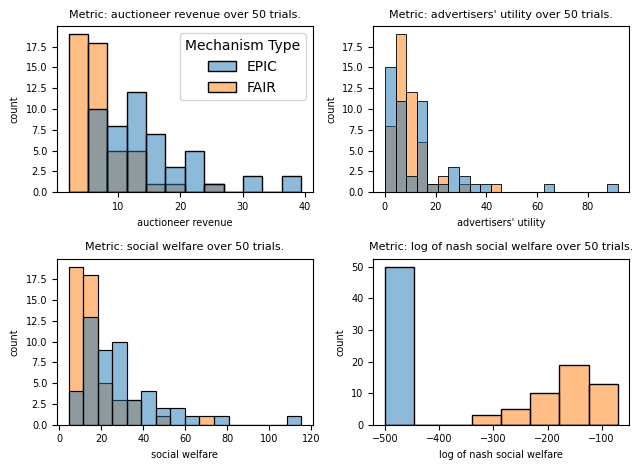

In [109]:
num_of_trials = 50
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5,hspace=0.5)

for m_id in range(4):
    i = m_id // 2
    j = m_id % 2
    values = np.array(epic[m_id] + fair[m_id])
    hues = ['EPIC'] * num_of_trials + ['FAIR'] * num_of_trials
    
    df = pd.DataFrame(data=list(zip(values, hues)), columns=[f'{metrics[m_id]}', 'Mechanism Type'])
    
    if m_id == 0:    
        sns.histplot(data=df, x=metrics[m_id], hue='Mechanism Type', ax=axs[i, j])
    else:
        sns.histplot(data=df, x=metrics[m_id], hue='Mechanism Type', ax=axs[i, j], legend=False)
        
    axs[i, j].xaxis.set_tick_params(labelsize=7)
    axs[i, j].yaxis.set_tick_params(labelsize=7)
    axs[i, j].set_xlabel(metrics[m_id], fontsize=7)
    axs[i, j].set_ylabel('count', fontsize=7)
    axs[i, j].set_title(f'Metric: {metrics[m_id]} over {num_of_trials} trials.', fontsize=8)

plt.tight_layout()
plt.savefig(f'epic_vs_fair_ideal_prompt_{prompt_id}.pdf')
plt.show()

### Efficient Mechanism
In this mechanism, we define
$$
q_i = \text{P}_\eta(a_i | x).
$$

In [110]:
eff = all_eff[prompt_id]

In [111]:
for m_id in range(len(metrics)):
    epic[m_id] = [x[m_id] for x in eff['epic']]
    fair[m_id] = [x[m_id] for x in eff['fair']]

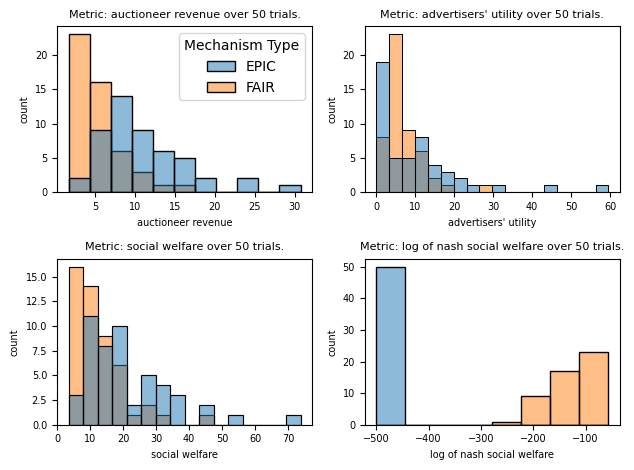

In [112]:
num_of_trials = 50
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5,hspace=0.5)

for m_id in range(4):
    i = m_id // 2
    j = m_id % 2
    values = np.array(epic[m_id] + fair[m_id])
    hues = ['EPIC'] * num_of_trials + ['FAIR'] * num_of_trials
    
    df = pd.DataFrame(data=list(zip(values, hues)), columns=[f'{metrics[m_id]}', 'Mechanism Type'])
    
    if m_id == 0:    
        sns.histplot(data=df, x=metrics[m_id], hue='Mechanism Type', ax=axs[i, j])
    else:
        sns.histplot(data=df, x=metrics[m_id], hue='Mechanism Type', ax=axs[i, j], legend=False)
        
    axs[i, j].xaxis.set_tick_params(labelsize=7)
    axs[i, j].yaxis.set_tick_params(labelsize=7)
    axs[i, j].set_xlabel(metrics[m_id], fontsize=7)
    axs[i, j].set_ylabel('count', fontsize=7)
    axs[i, j].set_title(f'Metric: {metrics[m_id]} over {num_of_trials} trials.', fontsize=8)

plt.tight_layout()
plt.savefig(f'epic_vs_fair_efficient_prompt_{prompt_id}.pdf')
plt.show()